In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import save_model
from datetime import timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Create output folder structure
output_dir = "Output_02"
subfolders = ["models", "plots", "results"]
for folder in subfolders:
    os.makedirs(os.path.join(output_dir, folder), exist_ok=True)

# Load dataset
data = pd.read_csv("Weather_Data.csv")

# Data preprocessing: fill missing or NaN values with column mean
data.fillna(data.mean(), inplace=True)

# Parse the date and set it as the index
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data.set_index('Date', inplace=True)
data.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

# Select features
features = ['Specific Humidity', 'Relative Humidity', 'Temperature', 'Precipitation']

# Normalize the data (important for LSTM)
scalers = {feature: MinMaxScaler(feature_range=(0, 1)) for feature in features}
scaled_data = {
    feature: scalers[feature].fit_transform(data[feature].values.reshape(-1, 1)) for feature in features
}

# The last 'Precipitation_mm' value of the dataset has date index value equal to 1990-12
data.tail(3)

# A new scaler is being initialized
data_scaler=MinMaxScaler()

# fit_transform function applied to all dataset's entries
scaled_set = data_scaler.fit_transform(data)

# A new TimeseriesGenerator is created to include the new scaled values, with batch_size = 1 of length=12
length = 11 # used for estimation of the future unknown values
data_generator = TimeseriesGenerator(scaled_set, scaled_set, length=length, batch_size=1)

# # Define LSTM model
# model = Sequential()
# model.add(LSTM(units=120, return_sequences=False, input_shape=(time_step, 1)))
# model.add(Dense(units=1))
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train model
# model.fit(X_train, y_train, epochs=250, batch_size=32, verbose=0)

<Figure size 1000x600 with 0 Axes>

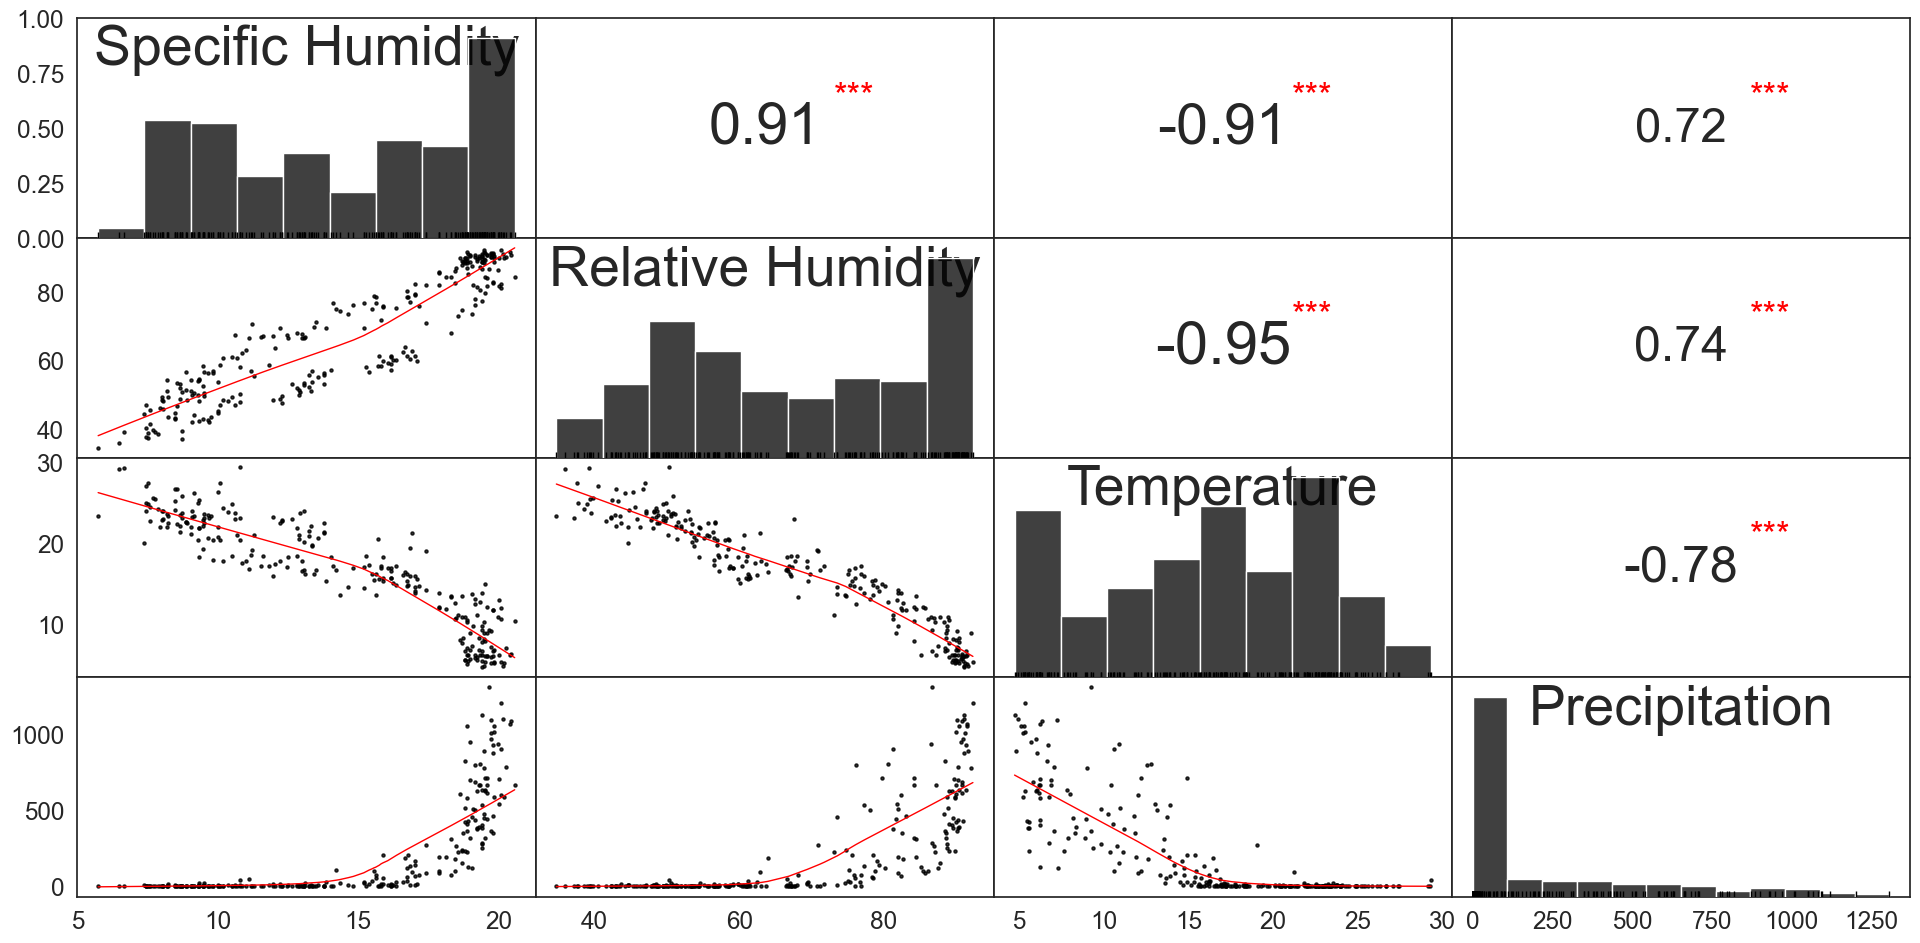

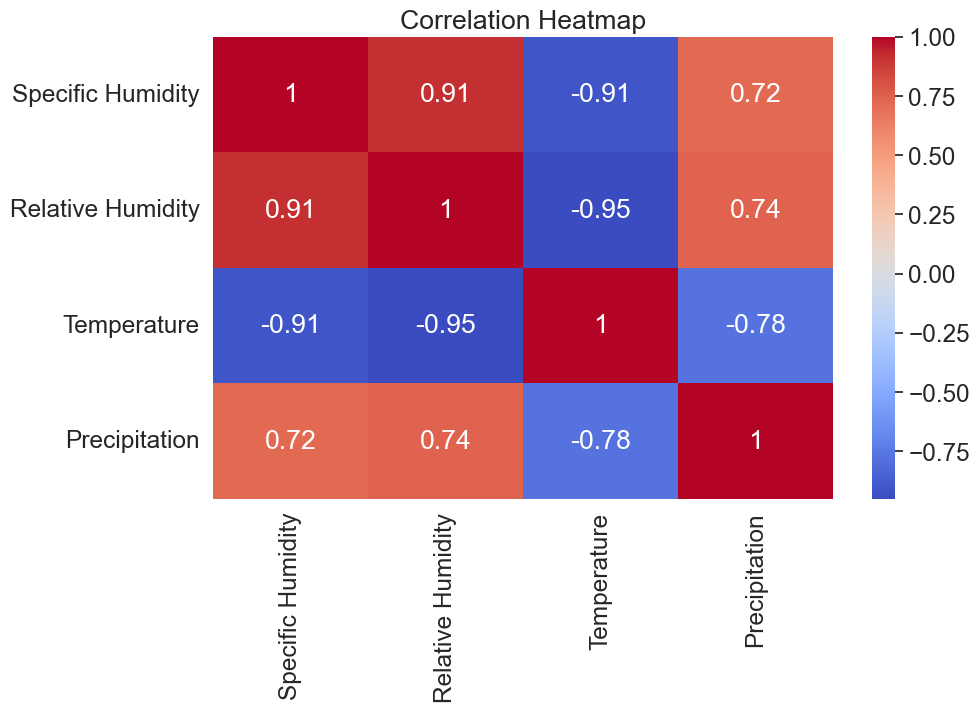

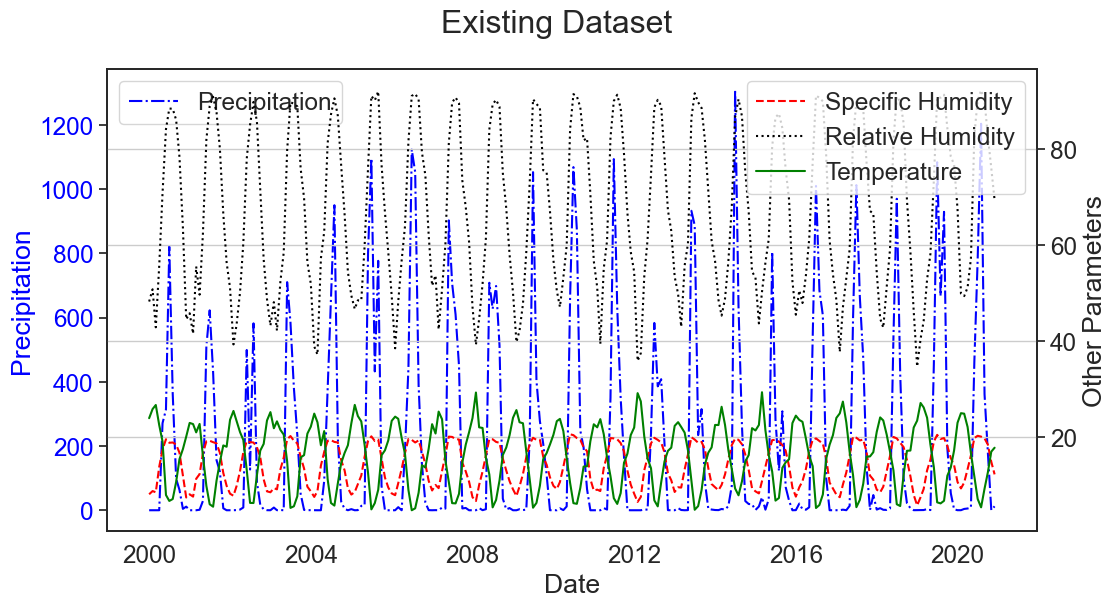

In [3]:
# Define features and target
features = data.columns

import statsmodels
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

font_size = 26

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = round(corr_r, 2)
    ax = plt.gca()
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

def corrfunc(x, y, **kws):
    r, p = stats.pearsonr(x, y)
    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    ax = plt.gca()
    ax.annotate(p_stars, xy=(0.65, 0.6), xycoords=ax.transAxes,
                color='red', fontsize=25)


df_comb = data
plt.figure(figsize=(10, 6))
sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(df_comb, aspect=2, diag_sharey=False, despine=False)
g.map_lower(sns.regplot, lowess=True, ci=False,
            line_kws={'color': 'red', 'lw': 1},
            scatter_kws={'color': 'black', 's': 5})
g.map_diag(sns.histplot, color='black',
           kde_kws={'color': 'red', 'cut': 0.5, 'lw': 1},
                     )
g.map_diag(sns.rugplot, color='black')
g.map_upper(corrdot)
g.map_upper(corrfunc)
g.fig.subplots_adjust(wspace=0, hspace=0)

# Remove axis labels
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

# Add titles to the diagonal axes/subplots
for ax, col in zip(np.diag(g.axes), df_comb.columns):
    ax.set_title(col, y=0.75, fontsize=40)

plt.savefig('./Output_01/plots/WQI_corr_1.png', dpi = 300)
plt.savefig(os.path.join(output_dir, "plots", "WQI_corr_1.png"), dpi = 300)
plt.show()
plt.show()
plt.close()
font_scale=1

plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.savefig("./Output_01/plots/correlation_heatmap.png")
plt.show()
plt.close()

# Define line styles and colors for each feature
line_styles = {
    'Precipitation': '-.',
    'Specific Humidity': '--',
    'Relative Humidity': ':',
    'Temperature': '-'
}
line_colors = {
    'Precipitation': 'blue',
    'Specific Humidity': 'red',
    'Relative Humidity': 'black',
    'Temperature': 'green'
}

# Function to plot the existing dataset with dual axes
def plot_existing_data(data):
    """Plot the existing dataset with separate axes for Precipitation and other parameters."""
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot precipitation on the first y-axis
    color = line_colors['Precipitation']
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Precipitation', color=color)
    ax1.plot(data.index, data['Precipitation'], label='Precipitation', color=color, linestyle=line_styles['Precipitation'])
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for other weather parameters
    ax2 = ax1.twinx()
    ax2.set_ylabel('Other Parameters')

    # Plot each feature with a unique line style and color
    for feature in features:
        if feature != 'Precipitation':
            ax2.plot(
                data.index, 
                data[feature], 
                label=feature, 
                linestyle=line_styles.get(feature, '-'),
                color=line_colors.get(feature, 'black')
            )
    
    # Add title and legends
    fig.suptitle("Existing Dataset")
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.grid()
    plt.savefig("./Output_01/plots/existing_data.png")
    plt.show()

# Plot the existing data
plot_existing_data(data)


In [4]:
# Function to create lagged dataset
def create_lagged_dataset(data, lag):
    lagged_data = pd.DataFrame(data, columns=['value'])
    for i in range(1, lag + 1):
        lagged_data[f'lag_{i}'] = lagged_data['value'].shift(i)
    lagged_data.dropna(inplace=True)
    return lagged_data.values

# Function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, mae

# Function to plot cross-validation results
def plot_cv_results(cv_results, feature, output_dir):
    plt.figure(figsize=(12, 8))
    for fold, (y_train_actual, y_train_pred, y_test_actual, y_test_pred) in enumerate(cv_results):
        plt.subplot(3, 2, fold + 1)

        # Plot actual vs predicted for training
        plt.plot(y_train_actual, label="Actual Train", color="blue")
        plt.plot(y_train_pred, label="Predicted Train", color="orange")

        # Plot actual vs predicted for testing
        plt.plot(np.arange(len(y_train_actual), len(y_train_actual) + len(y_test_actual)), y_test_actual, label="Actual Test", color="green")
        plt.plot(np.arange(len(y_train_actual), len(y_train_actual) + len(y_test_pred)), y_test_pred, label="Predicted Test", color="red")

        # Add metrics to the plot
        train_mse, train_mae = calculate_metrics(y_train_actual, y_train_pred)
        test_mse, test_mae = calculate_metrics(y_test_actual, y_test_pred)
        plt.title(f"Fold {fold + 1}\nTrain MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}\nTrain MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
    
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    plt.savefig(os.path.join(output_dir, "plots", f"{feature}_cv_results.png"))
    plt.show()



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/stepWARNING:tensorflow:5 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001D89556F600> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
5/5 ━

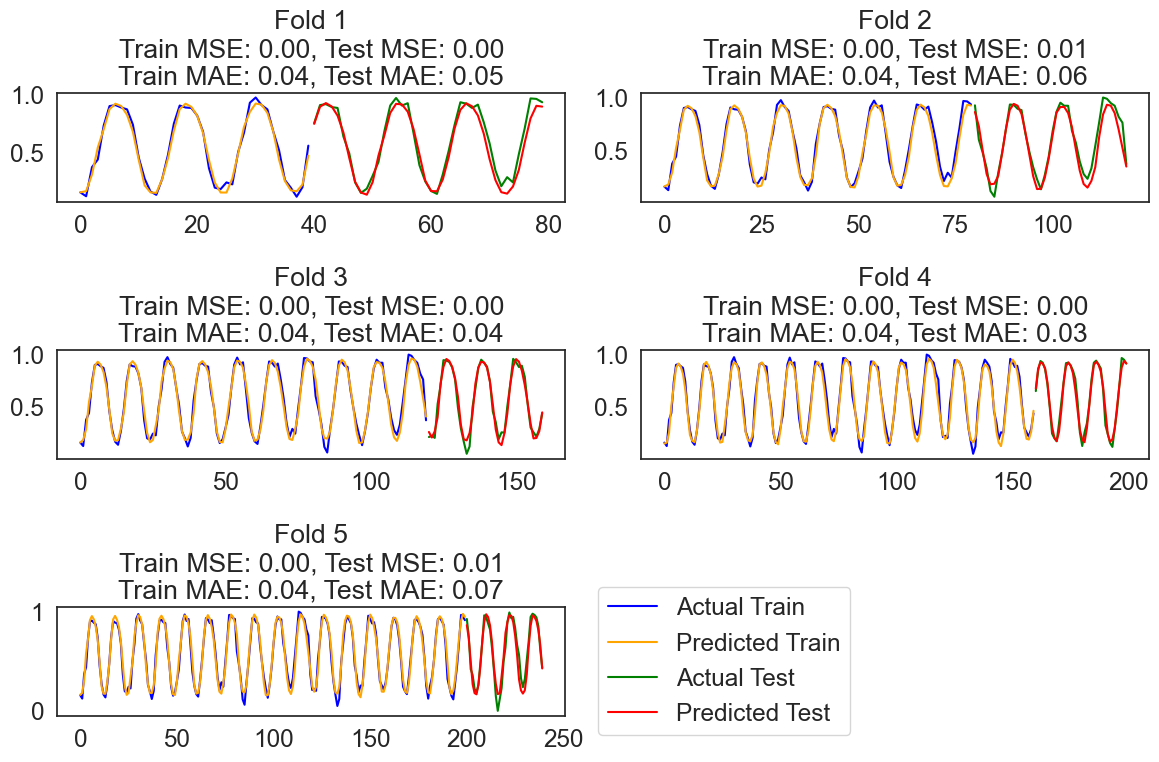

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━

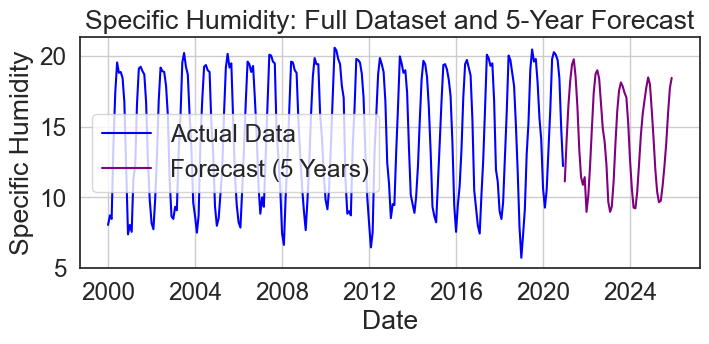

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


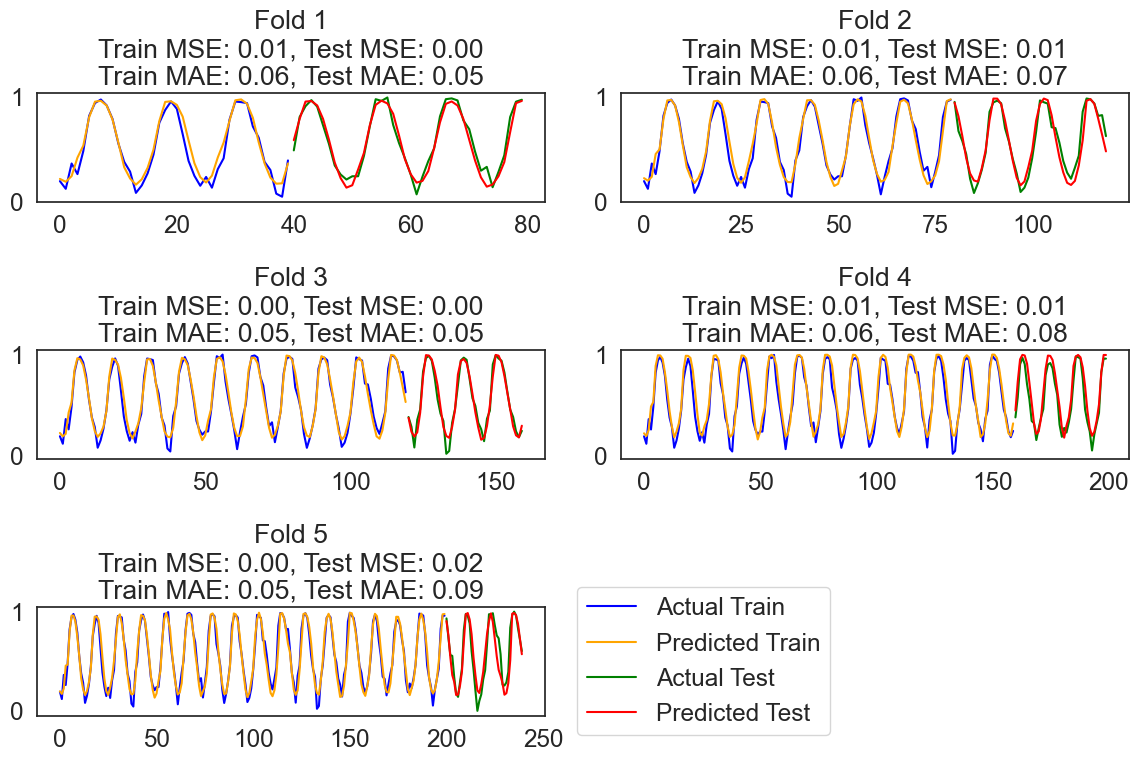

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━

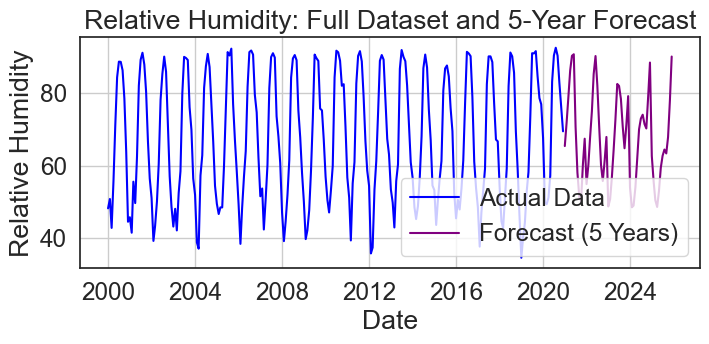

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


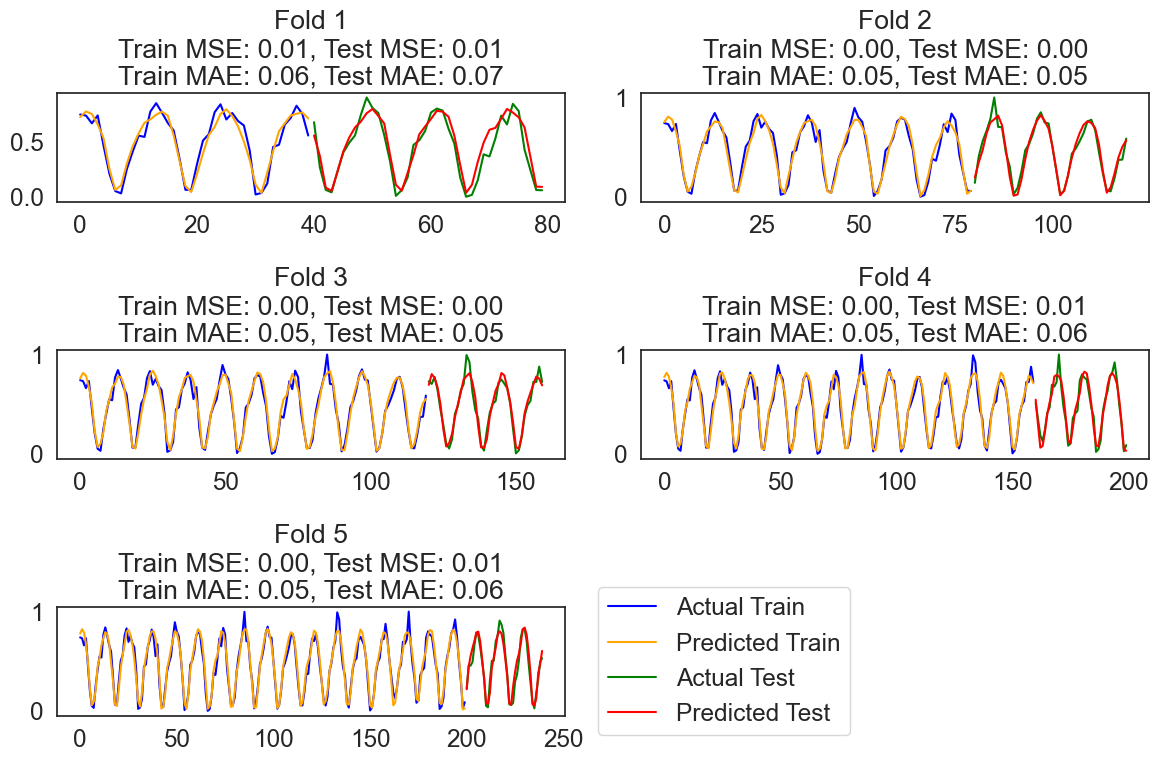

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━

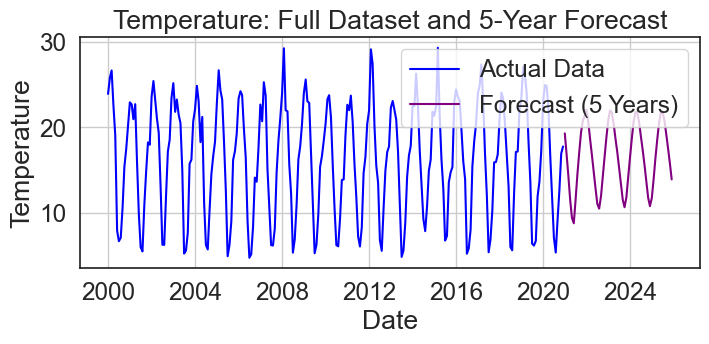

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


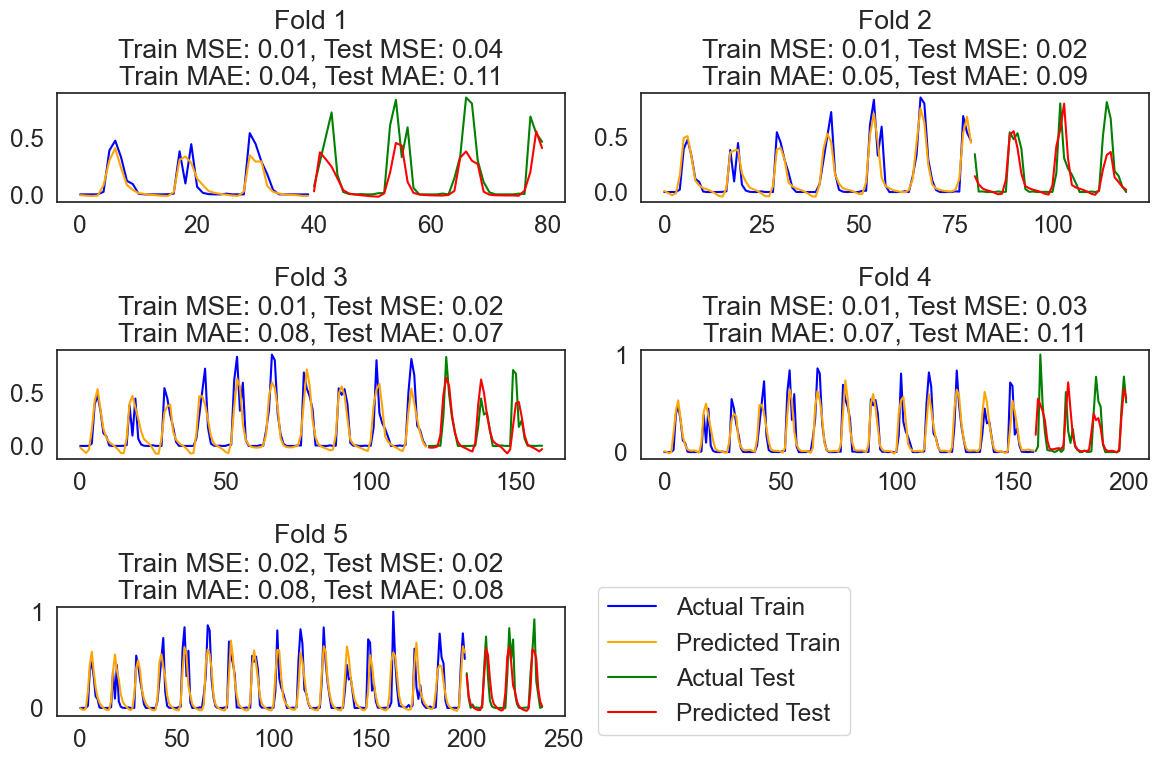

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

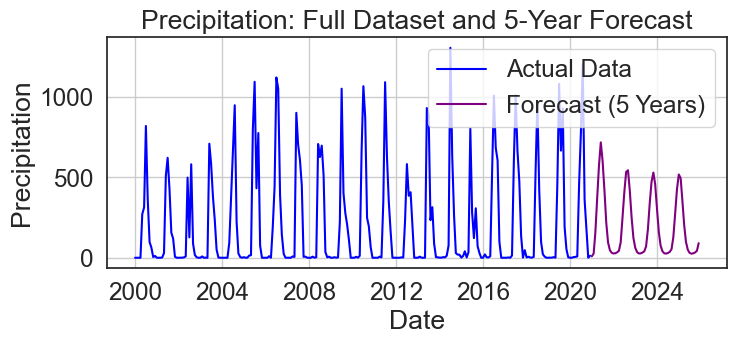

In [5]:
# Univariate prediction with lagged features
time_step = 12
forecast_steps = 60  # 5 years of monthly predictions
results = {}

ts_split = TimeSeriesSplit(n_splits=5)

for feature in features:
    # Create lagged dataset
    lagged_data = create_lagged_dataset(scaled_data[feature], lag=time_step)
    X_full = lagged_data[:, 1:]
    y_full = lagged_data[:, 0]
    X_full = X_full.reshape(X_full.shape[0], X_full.shape[1], 1)  # Reshape for LSTM input

    # Cross-validation
    cv_results = []
    for train_index, test_index in ts_split.split(X_full):
        X_train, X_test = X_full[train_index], X_full[test_index]
        y_train, y_test = y_full[train_index], y_full[test_index]

        # Define LSTM model
        model = Sequential()
        model.add(LSTM(units=120, activation='relu',return_sequences=False, input_shape=(time_step, 1)))
        model.add(Dense(units=1, activation='tanh'))
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train model
        model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0)

        # Make predictions
        y_train_pred = model.predict(X_train).flatten()
        y_test_pred = model.predict(X_test).flatten()

        # Store actual and predicted results
        cv_results.append((y_train, y_train_pred, y_test, y_test_pred))

    # Plot cross-validation results
    plot_cv_results(cv_results, feature, output_dir)

    # Train final model on full dataset
    final_model = Sequential()
    final_model.add(LSTM(units=120, activation='relu', return_sequences=False, input_shape=(time_step, 1)))
    final_model.add(Dense(units=1, activation='tanh'))
    final_model.compile(optimizer='adam', loss='mean_squared_error')
    final_model.fit(X_full, y_full, epochs=200, batch_size=32, verbose=0)
    

    # Save final model
    save_model(final_model, os.path.join(output_dir, "models", f"{feature}_lstm_model.keras"))

    # Forecast future data
    last_data = X_full[-1].reshape(1, time_step, 1)
    forecast = []
    for _ in range(forecast_steps):
        pred = final_model.predict(last_data)
        forecast.append(pred[0, 0])
        last_data = np.append(last_data[:, 1:, :], pred.reshape(1, 1, 1), axis=1)
    forecast_rescaled = scalers[feature].inverse_transform(np.array(forecast).reshape(-1, 1))
    forecast_dates = pd.date_range(data.index[-1] + timedelta(days=1), periods=forecast_steps, freq='M')

    # Save results
    results[feature] = {
        "forecast_rescaled": forecast_rescaled,
        "forecast_dates": forecast_dates,
    }
    
    # Generate forecast for the next 5 years (forecast_steps)
    last_data = X_full[-1].reshape(1, time_step, 1)  # Start with the last time step
    forecast = []
    for _ in range(forecast_steps):
        pred = final_model.predict(last_data, verbose=0)
        forecast.append(pred[0, 0])
        last_data = np.append(last_data[:, 1:, :], pred.reshape(1, 1, 1), axis=1)  # Update input for next prediction

    # Combine historical and forecasted data
    forecast_rescaled = scalers[feature].inverse_transform(np.array(forecast).reshape(-1, 1))
    combined_data = np.concatenate([scaled_data[feature], np.array(forecast).reshape(-1, 1)])
    combined_rescaled = scalers[feature].inverse_transform(combined_data)

    # Generate dates for the full dataset (historical + forecasted)
    historical_dates = data.index
    forecast_dates = pd.date_range(historical_dates[-1] + timedelta(days=1), periods=forecast_steps, freq='M')
    all_dates = historical_dates.append(forecast_dates)

    # Plot the combined historical and forecasted data
    plt.figure(figsize=(8, 3))
    plt.plot(historical_dates, scalers[feature].inverse_transform(scaled_data[feature]), label="Actual Data", color="blue")
    plt.plot(forecast_dates, forecast_rescaled, label="Forecast (5 Years)", color="purple")
    plt.title(f"{feature}: Full Dataset and 5-Year Forecast")
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.legend()
    plt.grid()

    # Save the updated plot
    plt.savefig(os.path.join(output_dir, "plots", f"{feature}_5year_forecast.png"))
    plt.show()

# Combine all forecast features into one CSV file
combined_forecast = pd.DataFrame({"Date": forecast_dates})
for feature in features:
    combined_forecast[feature] = results[feature]["forecast_rescaled"]

combined_forecast.to_csv(os.path.join(output_dir, "results", "5year_forecast_combined.csv"), index=False)
combined_forecast.to_csv(os.path.join("./Output_03", "input", "5year_forecast_combined.csv"), index=False)
